# **Weight Initialization for MLPs**
**Students:** Gulalaiy Khankhel & Osewuike Igue\
**Mentor:** Ms. Barbora Barancikova

In [5]:
# Package freezing in order to recreate the environment

!pip install -r requirements.txt

In [ ]:
# Import necessary packages

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import pandas as pd

## **Downloading Data From MNIST Dataset**

In [ ]:
# Enable the data file to be downloaded everytime the file is run.

!wget -O mnist.pkl https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz

--2024-12-20 11:10:21--  https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz [following]
--2024-12-20 11:10:22--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/octet-stream]
Saving to: ‘mnist.pkl’

mnist.pkl           100%[===================>]  16.26M  --.-KB/s    in 0.09s   

2024-12-20 11:10:22 (179 MB/s) - ‘mn

In [ ]:
import gzip
import pickle
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data."""
    with gzip.open('mnist.pkl', 'rb') as f:
        training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    return (training_data, validation_data, test_data)

class MNISTDataset(Dataset):
    """Custom PyTorch Dataset for MNIST data."""
    '''Bridges the numpy arrays and PyTorch’s data processing pipeline'''
    def __init__(self, data, labels, transform=None):
        self.data = torch.tensor(data, dtype=torch.float32)  # Normalize pixel values
        self.labels = torch.tensor(labels, dtype=torch.long)  # PyTorch requires labels as LongTensors
        self.transform = transform

    def __len__(self):
        return len(self.data)
        """ Sample use: len(train_dataset) """

    def __getitem__(self, index):
        x = self.data[index]      # Get the input data at the specified index
        y = self.labels[index]    # Get the label at the specified index
        if self.transform:        # Apply any preprocessing (if specified)
            x = self.transform(x)
        return x, y               # Return the sample (data and label)
        """ single_sample = train_dataset[10]  # Get the 10th sample """

def load_data_for_pytorch(batch_size=32):
    """Prepare data loaders for PyTorch."""
    tr_d, va_d, te_d = load_data() # obtain training_data, validation_data, test_data

    # Convert the data into PyTorch-compatible Datasets
    train_dataset = MNISTDataset(tr_d[0], tr_d[1])
    validation_dataset = MNISTDataset(va_d[0], va_d[1])
    test_dataset = MNISTDataset(te_d[0], te_d[1])

    # Wrap datasets with DataLoader for batching
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader, test_loader

# Example usage
batch_size = 150
train_dataset, validation_dataset, test_dataset = load_data_for_pytorch(batch_size=batch_size)

# Check one batch
for x, y in train_dataset:
    print("Input shape:", x.shape)  # Should be [batch_size, 784]
    print("Labels shape:", y.shape)  # Should be [batch_size]
    break # I only want to view the first one to confirm what the data is


Input shape: torch.Size([150, 784])
Labels shape: torch.Size([150])


# **Analyzing the Performance of Different Weight Initialization Methods with Different Activation Functions & Optimizers**

## **Implementation of the MLP**

This cell defines the `MLP` (**Multilayer Perceptron**) class, which is a fully customizable neural network model implemented using `PyTorch`'s `nn.Module`.

Here's a breakdown of its functionality:

**A. Initialization** (`__init__`):

- Input Parameters:

  - **sizes**: A list specifying the number of neurons in each layer, including input, hidden, and output layers.
  - **activation**: The activation function to use (e.g., sigmoid, tanh, or relu).
  - **initialization**: The weight initialization strategy (e.g., random, xavier, he, or zero).
  - **learning_rate**: The learning rate for the optimizer.
- Creates the `MLP` architecture as a sequence of fully connected layers (`nn.Linear`) and stores them in a `ModuleList`.
- Configures cross-entropy as the default loss function for classification tasks and initializes lists to track training/test loss and accuracy.

**B. Forward Pass** (`forward`):

- Implements the computation of activations through each layer based on the selected activation function.
- Supports `sigmoid`, `tanh`, and `relu`, with error handling for unsupported activations.

**C. Weight Initialization** (`_initialize_weights`):

- Configures weights and biases for each layer using the specified initialization strategy:
  - **Zero**: All weights and biases set to zero (baseline for comparison).
  - **Random**: Weights initialized with a standard normal distribution.
  - **Xavier**: Balances input/output variance, ideal for `tanh`/`sigmoid` activations.
  - **He**: Optimized for `relu`, prevents vanishing/exploding gradients.

**D. Optimizer Configuration** (`configure_optimizer`):

- Supports SGD and Adam optimizers with user-defined learning rates.

**E. Training and Evaluation**:

- `train_model`: Trains the MLP over a specified number of epochs, logging loss and accuracy metrics.
- `valuate_model`: Computes test loss and accuracy for validation data.

**F. Visualization Methods**:

- `plot_loss_accuracy`: Plots training/test loss and test accuracy trends across epochs.
- `plot_weight_distributions`: Visualizes the weight distribution across layers to analyze parameter scaling.
- `plot_activation_distributions`: Displays the spread of activation values across layers, helping identify saturation or dead neurons.

In [ ]:
import torch.nn.functional as F

In [ ]:
class MLP(nn.Module):
    def __init__(self, sizes, activation = 'sigmoid', initialization = 'random', learning_rate = 0.01):
        super().__init__()
        layers = []
        for i in range(len(sizes) - 1): # exclude last layer
            layers.append(nn.Linear(sizes[i], sizes[i + 1])) # append the necessary dimensions to the list
        self.layers = nn.ModuleList(layers)
        self.activation = activation
        self.initialization = initialization

        self.learning_rate = learning_rate # learning rate for the model
        self.optimizer = None # initiate the optimizer function
        self.loss_fn = nn.CrossEntropyLoss() # make use of cross entropy loss

        # store losses and accuracies for plotting
        self.losses = []
        self.accuracies = []
        self.test_losses = []

        # initialize weights and biases (parameters)
        self._initialize_weights()

    def forward(self, x):
        for layer in self.layers:
            if self.activation == "sigmoid":
                x = torch.sigmoid(layer(x))
            elif self.activation == "tanh":
                x = torch.tanh(layer(x))
            elif self.activation == "relu":
                x = torch.relu(layer(x))
            else:
                raise ValueError(f"Unsupported activation: {self.activation}")
        return x

    def configure_optimizer(self, optimizer_type='SGD'):
        """Set up the optimizer."""
        if optimizer_type == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)
        elif optimizer_type == 'Adam':
            self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer_type}")

    def _initialize_weights(self):
        """
        Initializes weights of the layers based on the specified initialization technique.
        """
        if self.initialization == 'zero':
          for layer in self.layers:
              if isinstance(layer, nn.Linear):  # Ensure we're working with linear layers
                  # Zero initialization: Set weights and biases to 0
                  nn.init.zeros_(layer.weight)
                  nn.init.zeros_(layer.bias)
        elif self.initialization == 'random':
          for layer in self.layers:
              if isinstance(layer, nn.Linear):
                  # Random Gaussian initialization with mean=0 and std=1
                  nn.init.normal_(layer.weight, mean=0, std=1)
        elif self.initialization == 'xavier':
          for layer in self.layers:
              if isinstance(layer, nn.Linear):
                  # Xavier initialization: Set weights using Xavier uniform
                  nn.init.xavier_uniform_(layer.weight)
        elif self.initialization == 'he':
          for layer in self.layers:
              if isinstance(layer, nn.Linear):
                  # He initialization: Set weights using He uniform
                  nn.init.kaiming_uniform_(layer.weight)

    def train_model(self, train_loader, test_loader, epochs):
        """Train the model using the provided DataLoader and evaluate accuracy after each epoch."""
        if self.optimizer is None:
            raise ValueError("Optimizer not configured. Call `configure_optimizer()` first.")

        for epoch in range(epochs):
            self.train()
            epoch_loss = 0.0
            for batch_x, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self(batch_x)
                loss = self.loss_fn(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)
            self.losses.append(avg_loss)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

            # Evaluate model
            test_loss, accuracy = self.evaluate_model(test_loader)
            self.test_losses.append(test_loss)
            self.accuracies.append(accuracy)
            print(f"Epoch {epoch + 1}, Accuracy: {accuracy * 100:.2f}%")

        # Use this function to plot the visualizations
        self.plot_loss_accuracy()

    def evaluate_model(self, test_loader):
        """Evaluate the model using the provided DataLoader."""
        self.eval()
        total_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                outputs = self(batch_x)
                loss = self.loss_fn(outputs, batch_y)
                total_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == batch_y).sum().item()
                total += batch_y.size(0)
        accuracy = correct / total
        return total_loss / len(test_loader), accuracy

    def plot_loss_accuracy(self):
        """Plot loss and accuracy curves."""
        sns.set(style="whitegrid")

        # Loss plot
        plt.figure(figsize=(8, 6))
        sns.lineplot(x=range(1, len(self.losses) + 1), y=self.losses, label='Training Loss')
        sns.lineplot(x=range(1, len(self.test_losses) + 1), y=self.test_losses, label='Test Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.ylim(bottom=0, top=3)
        plt.show()

        # Accuracy plot
        plt.figure(figsize=(8, 6))
        sns.lineplot(x=range(1, len(self.accuracies) + 1), y=self.accuracies, label='Test Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.ylim(bottom=0.0, top=1.00)
        plt.show()

    def plot_weight_distributions(self, title='Weight Distribution'):
        """Plot weight distributions for all layers."""
        weights = [layer.weight.data.cpu().numpy().flatten() for layer in self.layers]
        weights_flat = [w for layer_weights in weights for w in layer_weights]
        sns.histplot(weights_flat, kde=True)
        plt.title(title)
        plt.xlabel('Weight Values')
        plt.ylabel('Frequency')
        plt.show()

    def plot_activation_distributions(self, data_loader):
        """Plot activation values across layers."""
        activation_values = {'Layer': [], 'Activation': []}
        self.eval()
        with torch.no_grad():
            for batch_x, _ in data_loader:
                x = batch_x
                for i, layer in enumerate(self.layers):
                    x = layer(x)
                    x = torch.sigmoid(x) if self.activation == 'sigmoid' else x
                    activation_values['Layer'].extend([f'Layer {i+1}'] * x.numel())
                    activation_values['Activation'].extend(x.cpu().numpy().flatten())

        activation_df = pd.DataFrame(activation_values)
        sns.boxplot(data=activation_df, x='Layer', y='Activation')
        plt.title('Activation Distribution Across Layers')
        plt.show()

## **Test of the MLP**

This cell demonstrates the process of defining and preparing the MLP model for training.

**A. Defining the Model Architecture**

- The model requires a list of layer sizes to define the structure of the network (input, hidden, and output layers).
- Parameters for the **weight initialization technique** and **activation function** must be specified:
  - **Weight Initialization**: Controls how the initial weights and biases are set, influencing gradient flow and convergence speed. Examples include:
    - `random`: Initializes weights randomly (normal distribution).
    - `xavier`: Balances variance for symmetric activations like `relu` or `tanh`.
    - `he`: Balanced variance for symmetric activations but also optimized for `relu`, preventing vanishing/exploding gradients.
  - **Activation Function**: Specifies the non-linearity applied after each layer  
    - `sigmoid`
    - `relu`
    - `tanh`

**B. Configuring the Optimizer**

After defining the model, the optimizer must be selected to guide weight updates during training:

- **Optimizer Types**

  Common choices include:
  - `SGD` (Stochastic Gradient Descent): Updates weights incrementally, suitable for cases requiring stable generalization.
  - `Adam`: Combines momentum and adaptive learning rates, often faster for convergence.
- **Learning Rate**: Specifies the step size for weight updates. A smaller learning rate ensures stability, while a larger one speeds up convergence but risks instability.

**C. Purpose of Parameters**

By explicitly specifying the weight initialization technique and optimizer settings, you ensure the model is tailored to the task at hand, balancing convergence speed, stability, and generalization.

In [ ]:
# Define the model
sizes = [784, 128, 64, 10]
model = MLP(sizes, activation='relu', initialization='xavier',learning_rate=0.01)

# Configure optimizer ('Adam' or 'SGD')
model.configure_optimizer(optimizer_type='SGD')

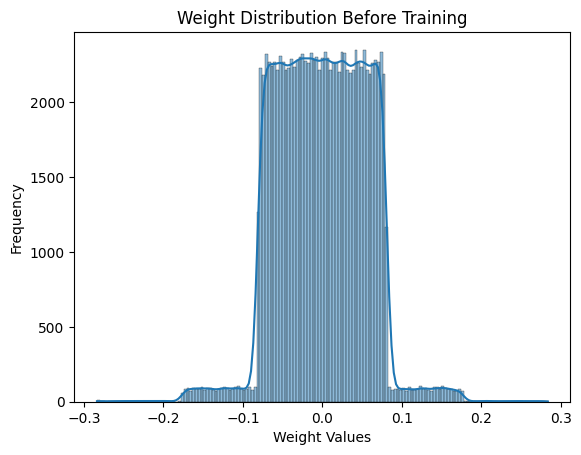

In [ ]:
# Before training
model.plot_weight_distributions(title="Weight Distribution Before Training")

Epoch 1/35, Loss: 1.9234
Epoch 1, Accuracy: 64.79%
Epoch 2/35, Loss: 1.1231
Epoch 2, Accuracy: 73.12%
Epoch 3/35, Loss: 0.8995
Epoch 3, Accuracy: 80.68%
Epoch 4/35, Loss: 0.6912
Epoch 4, Accuracy: 82.14%
Epoch 5/35, Loss: 0.6200
Epoch 5, Accuracy: 82.68%
Epoch 6/35, Loss: 0.5817
Epoch 6, Accuracy: 83.16%
Epoch 7/35, Loss: 0.5556
Epoch 7, Accuracy: 83.51%
Epoch 8/35, Loss: 0.5362
Epoch 8, Accuracy: 83.60%
Epoch 9/35, Loss: 0.5211
Epoch 9, Accuracy: 83.85%
Epoch 10/35, Loss: 0.5077
Epoch 10, Accuracy: 83.90%
Epoch 11/35, Loss: 0.4970
Epoch 11, Accuracy: 84.11%
Epoch 12/35, Loss: 0.4875
Epoch 12, Accuracy: 84.36%
Epoch 13/35, Loss: 0.4789
Epoch 13, Accuracy: 84.47%
Epoch 14/35, Loss: 0.4709
Epoch 14, Accuracy: 84.60%
Epoch 15/35, Loss: 0.4637
Epoch 15, Accuracy: 84.73%
Epoch 16/35, Loss: 0.4577
Epoch 16, Accuracy: 84.80%
Epoch 17/35, Loss: 0.4509
Epoch 17, Accuracy: 84.91%
Epoch 18/35, Loss: 0.4454
Epoch 18, Accuracy: 85.01%
Epoch 19/35, Loss: 0.4395
Epoch 19, Accuracy: 85.23%
Epoch 20/35

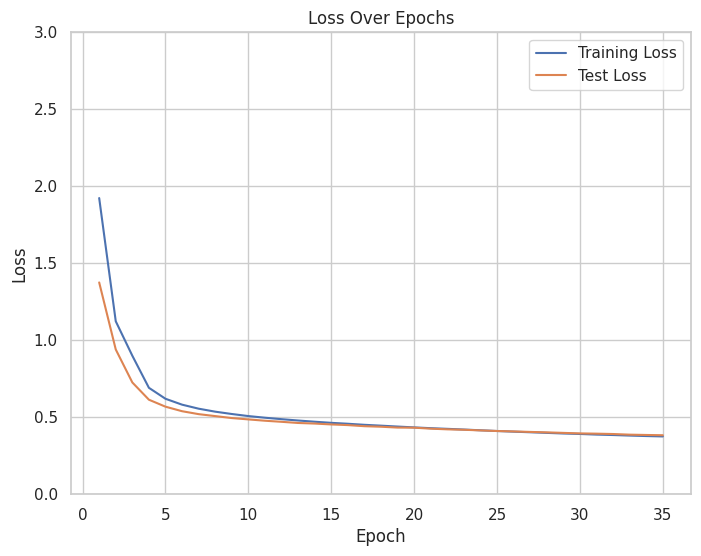

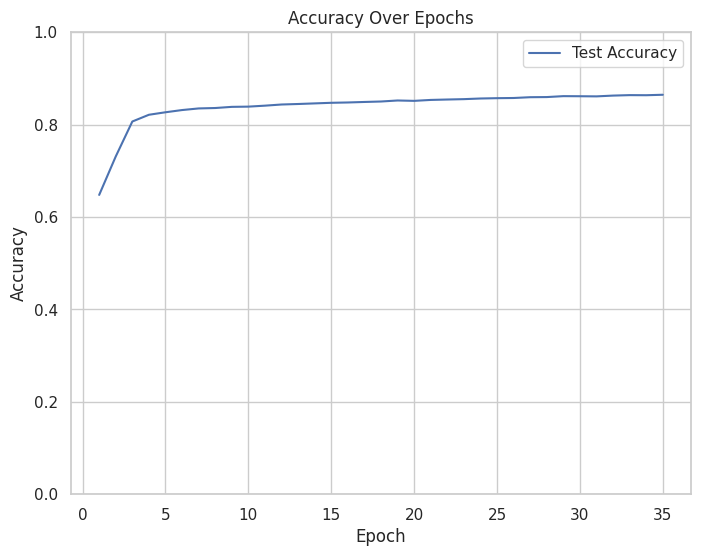

In [ ]:
# Train the model for 35 epochs
model.train_model(train_dataset, validation_dataset, epochs=35)

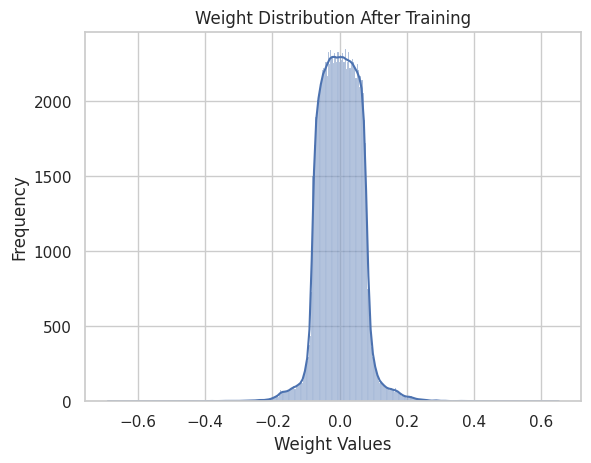

In [ ]:
# After training (repeat after `train_model`)
model.plot_weight_distributions(title="Weight Distribution After Training")

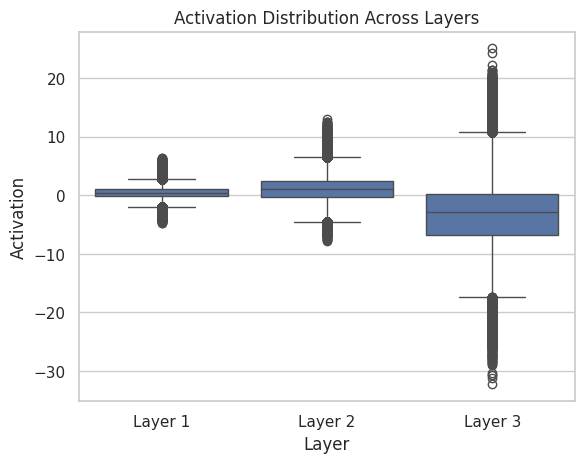

In [ ]:
# Use a small sample for activations visualization
model.plot_activation_distributions(test_dataset)

In [ ]:
final_test_loss, final_test_accuracy = model.evaluate_model(test_dataset)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy * 100:.2f}%")

Final Test Loss: 0.3826, Final Test Accuracy: 86.47%


# **Analyzing Performance of Different Weight Initialization Methods with Varying MLP Depth**

Here, we test how our MLP performs when different initialization methods are used in a 1-hidden layer MLP, versus a 6-hidden layer MLP. Here are the important aspects of our code for this experiment:


- The model uses a flexible architecture which allows for an arbitrary number of layers to be defined by the `sizes` list. Each pair of consecutive values in `sizes` specifies the input and output dimensions for a layer. For our code we have used `1` and `6` hidden layers.
- The ReLU activation function is automatically applied after each hidden layer but omitted for the final output layer. This ensures that the output matches the desired dimensionality for classification tasks (e.g., logits for CrossEntropyLoss)
- The `init_method` parameter allows us to easily switch between different initialization methods depending on which method we want to test out.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, sizes, init_method='xavier', learning_rate=0.01):
        super().__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:  # Add activation functions for all layers except the last
                layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)

        self.init_method = init_method
        self.learning_rate = learning_rate
        self.optimizer = optim.SGD(self.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()

        self.losses = []
        self.accuracies = []
        self.test_losses = []

        self._initialize_weights()

    def forward(self, x):
        return self.layers(x)

    def _initialize_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if self.init_method == 'xavier':
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.zeros_(layer.bias)
                elif self.init_method == 'he':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                    nn.init.zeros_(layer.bias)
                elif self.init_method == 'random':
                    nn.init.normal_(layer.weight, mean=0.0, std=1.0)
                    nn.init.zeros_(layer.bias)
                elif self.init_method == 'zero':
                    nn.init.zeros_(layer.weight)
                    nn.init.zeros_(layer.bias)
                else:
                    raise ValueError(f"Unsupported initialization method: {self.init_method}")

    def train_model(self, train_loader, test_loader, epochs):
        for epoch in range(epochs):
            self.train()
            epoch_loss = 0.0
            for batch_x, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self(batch_x)
                loss = self.loss_fn(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)
            self.losses.append(avg_loss)

            test_loss, accuracy = self.evaluate_model(test_loader)
            self.test_losses.append(test_loss)
            self.accuracies.append(accuracy)

            print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

        self.plot_loss_accuracy()

    def evaluate_model(self, test_loader):
        self.eval()
        total_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                outputs = self(batch_x)
                loss = self.loss_fn(outputs, batch_y)
                total_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == batch_y).sum().item()
                total += batch_y.size(0)
        accuracy = correct / total
        return total_loss / len(test_loader), accuracy

    def plot_loss_accuracy(self):
        # Loss plot
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(self.losses) + 1), self.losses, label='Training Loss')
        plt.plot(range(1, len(self.test_losses) + 1), self.test_losses, label='Test Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Accuracy plot
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, label='Test Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()


In [ ]:
# Experiment setup
batch_size = 128
train_loader, validation_loader, test_loader = load_data_for_pytorch(batch_size=batch_size)

Training & Testing model with 1 hidden layer...
Epoch 1/35, Training Loss: 19.3966, Test Loss: 7.7656, Test Accuracy: 72.52%
Epoch 2/35, Training Loss: 6.9574, Test Loss: 5.2969, Test Accuracy: 79.35%
Epoch 3/35, Training Loss: 5.1342, Test Loss: 4.2380, Test Accuracy: 81.98%
Epoch 4/35, Training Loss: 4.2215, Test Loss: 3.6124, Test Accuracy: 83.35%
Epoch 5/35, Training Loss: 3.6418, Test Loss: 3.2298, Test Accuracy: 84.34%
Epoch 6/35, Training Loss: 3.2250, Test Loss: 2.8917, Test Accuracy: 85.29%
Epoch 7/35, Training Loss: 2.9100, Test Loss: 2.6522, Test Accuracy: 85.86%
Epoch 8/35, Training Loss: 2.6576, Test Loss: 2.4635, Test Accuracy: 86.16%
Epoch 9/35, Training Loss: 2.4516, Test Loss: 2.3070, Test Accuracy: 86.70%
Epoch 10/35, Training Loss: 2.2755, Test Loss: 2.1684, Test Accuracy: 86.96%
Epoch 11/35, Training Loss: 2.1258, Test Loss: 2.0313, Test Accuracy: 87.23%
Epoch 12/35, Training Loss: 1.9890, Test Loss: 1.9403, Test Accuracy: 87.62%
Epoch 13/35, Training Loss: 1.8763, 

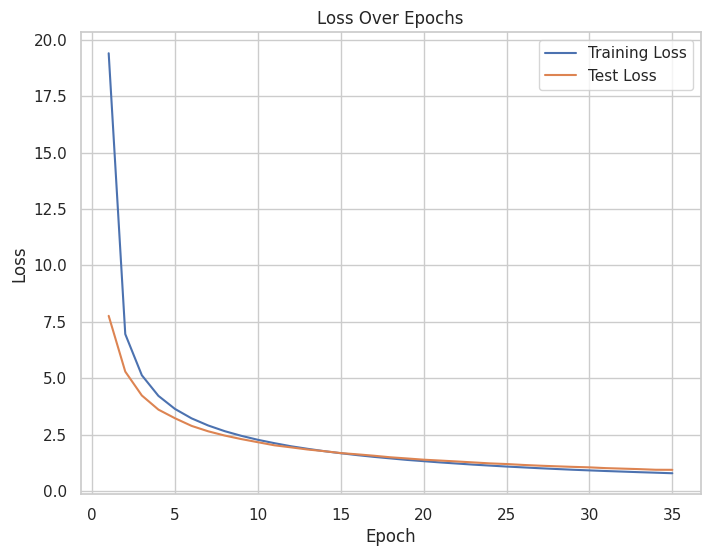

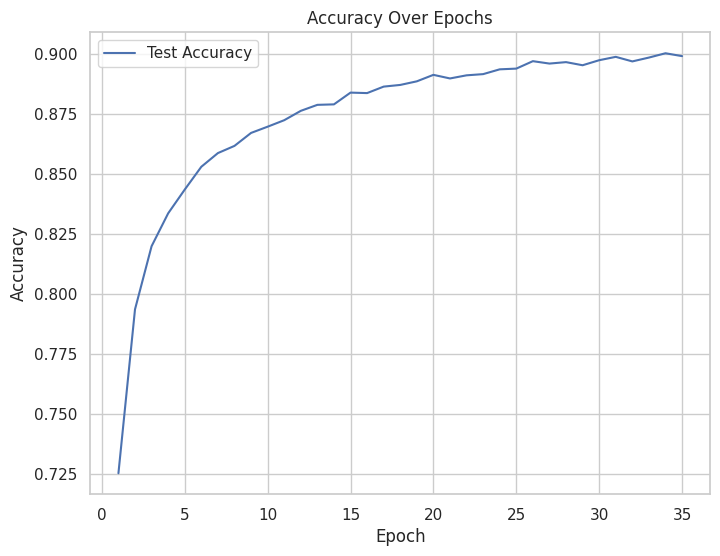

In [ ]:
# 1 Hidden Layer
shallow_sizes = [784, 128, 10]
shallow_model = MLP(shallow_sizes, init_method='random', learning_rate=0.01)

print("Training & Testing model with 1 hidden layer...")
shallow_model.train_model(train_loader, test_loader, epochs=35)

Training & Testing model with 6 hidden layers...
Epoch 1/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 2/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 3/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 4/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 5/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 6/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 7/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 8/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 9/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 10/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 11/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 12/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 13/35, Training Loss: nan, Test Loss: nan, Test Accuracy: 9.80%
Epoch 14/35, Training Loss: nan, Test Loss: nan, T

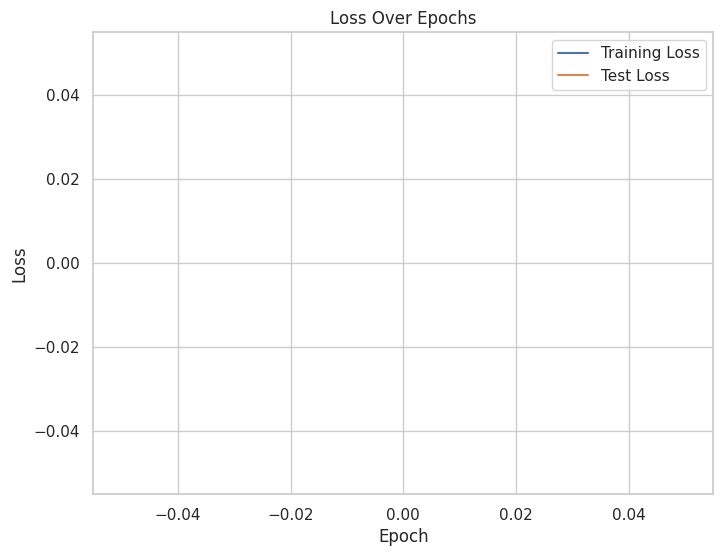

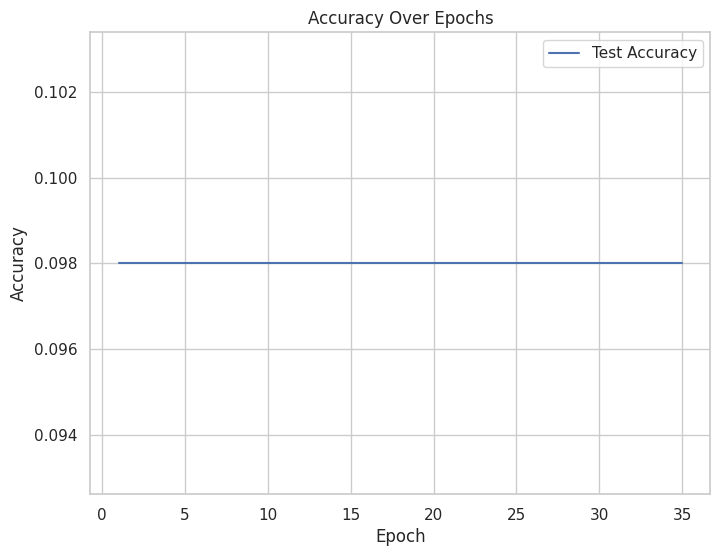

In [ ]:
# 6 Hidden Layers
deep_sizes = [784, 512, 256, 128, 64, 32, 16, 10]
deep_model = MLP(deep_sizes, init_method='random', learning_rate=0.01)

print("Training & Testing model with 6 hidden layers...")
deep_model.train_model(train_loader, test_loader, epochs=35)

**Main Observations:**

* With 1 hidden layer, **random initialization** performs decently, reaching around 90% test accuracy, however, with 6 hidden layers, the loss becomes **nan**, indicating **gradient instability** caused by using random initialization in a deeper MLP model.
* **Xavier and He** perform consistently well with both the shallower and deeper model.
* **Zero Initialization** fails to perform well in either cases, due to the MLP failing to learn with zero initialization selected.